# Customer Segmentation

**Problem Statement**:
    An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4 and P5). After intensive market research, they’ve deduced that the behavior of new market is similar to their existing market. 

In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for different segment of customers. This strategy has work exceptionally well for them. They plan to use the same strategy on new markets and have identified 2627 new potential customers. 

You are required to help the manager to predict the right group of the new customers.



In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import accuracy_score



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#Importing Train and Test
train_df=pd.read_csv('/kaggle/input/customer-segmentation/Train_aBjfeNk.csv')
test_df=pd.read_csv('/kaggle/input/customer-segmentation/Test_LqhgPWU.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2627 non-null   int64  
 1   Gender           2627 non-null   object 
 2   Ever_Married     2577 non-null   object 
 3   Age              2627 non-null   int64  
 4   Graduated        2603 non-null   object 
 5   Profession       2589 non-null   object 
 6   Work_Experience  2358 non-null   float64
 7   Spending_Score   2627 non-null   object 
 8   Family_Size      2514 non-null   float64
 9   Var_1            2595 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 205.4+ KB


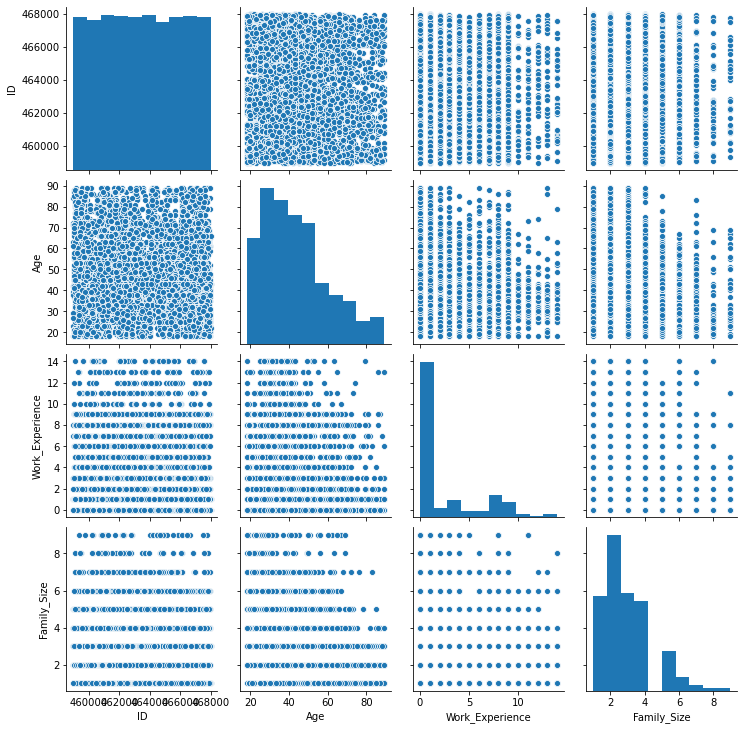

In [5]:
sns.pairplot(train_df)

In [6]:
combine_set=pd.concat([train_df,test_df],ignore_index=True)
combine_set['Ever_Married'].fillna('unknown',inplace=True)
combine_set['Graduated'].fillna('unknown',inplace=True)
combine_set['Profession'].fillna('unknown',inplace=True)
combine_set['Work_Experience'].fillna(combine_set['Work_Experience'].mode()[0], inplace=True)
combine_set['Family_Size'].fillna(0,inplace=True)
combine_set['Var_1'].fillna('Cat_0',inplace=True)
combine_set.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,A


In [7]:
#Adding more Features
combine_set['Unique_profession_per_agegroup']=combine_set.groupby(['Age'])['Profession'].transform('nunique')
combine_set['Unique_agegroup_per_profession']=combine_set.groupby(['Profession'])['Age'].transform('nunique')
combine_set['Age_Family_size']=combine_set.groupby(['Age'])['Family_Size'].transform('nunique')
combine_set.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Unique_profession_per_agegroup,Unique_agegroup_per_profession,Age_Family_size
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D,10,46,10.0
1,462643,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,A,9,53,9.0
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B,9,53,8.0
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B,9,52,8.0
4,462669,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,A,10,63,9.0


In [8]:
combine_set['Var_1'].value_counts()

Cat_6    6910
Cat_4    1475
Cat_3    1089
Cat_2     563
Cat_7     269
Cat_1     167
Cat_5     114
Cat_0     108
Name: Var_1, dtype: int64

In [9]:
combine_set_ann=pd.get_dummies(combine_set,columns=['Gender','Ever_Married','Graduated','Spending_Score','Profession','Var_1'],drop_first=True)
print(combine_set_ann.shape)
combine_set_ann.head(10)

(10695, 31)


,ID,Age,Work_Experience,Family_Size,Segmentation,Unique_profession_per_agegroup,Unique_agegroup_per_profession,Age_Family_size,Gender_Male,Ever_Married_Yes,...,Profession_Lawyer,Profession_Marketing,Profession_unknown,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,462809,22,1.0,4.0,D,10,46,10.0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,462643,38,1.0,3.0,A,9,53,9.0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,466315,67,1.0,1.0,B,9,53,8.0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,461735,67,0.0,2.0,B,9,52,8.0,1,1,...,1,0,0,0,0,0,0,0,1,0
4,462669,40,1.0,6.0,A,10,63,9.0,0,1,...,0,0,0,0,0,0,0,0,1,0
5,461319,56,0.0,2.0,C,10,66,9.0,1,1,...,0,0,0,0,0,0,0,0,1,0
6,460156,32,1.0,3.0,C,9,46,10.0,1,0,...,0,0,0,0,0,0,0,0,1,0
7,464347,33,1.0,3.0,D,9,46,10.0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,465015,61,0.0,3.0,D,10,53,8.0,0,1,...,0,0,0,0,0,0,0,0,0,1
9,465176,55,1.0,4.0,C,10,66,10.0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [10]:
#Encoding Category Variables
def frequency_encoding(col):
    fe=combine_set.groupby(col).size()/len(combine_set)
    combine_set[col]=combine_set[col].apply(lambda x: fe[x])
#     le=LabelEncoder()
#     combine_set[col]=le.fit_transform(combine_set[col])

In [11]:
for col in list(combine_set.select_dtypes(include=['object']).columns):
    if col!='Segmentation':
        frequency_encoding(col)
    
    
combine_set.head(5)
    

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Unique_profession_per_agegroup,Unique_agegroup_per_profession,Age_Family_size
0,462809,0.546143,0.405984,22,0.376157,0.163628,1.0,0.607200,4.0,0.137915,D,10,46,10.0
1,462643,0.453857,0.576251,38,0.614306,0.087424,1.0,0.243011,3.0,0.137915,A,9,53,9.0
2,466315,0.453857,0.576251,67,0.614306,0.087424,1.0,0.607200,1.0,0.646096,B,9,53,8.0
3,461735,0.546143,0.576251,67,0.614306,0.078915,0.0,0.149790,2.0,0.646096,B,9,52,8.0
4,462669,0.453857,0.576251,40,0.614306,0.116877,1.0,0.149790,6.0,0.646096,A,10,63,9.0


In [12]:
train_df=combine_set[combine_set['Segmentation'].isnull()==False]
train_ann=combine_set_ann[combine_set_ann['Segmentation'].isnull()==False]
test_df=combine_set[combine_set['Segmentation'].isnull()==True]
test_ann=combine_set_ann[combine_set_ann['Segmentation'].isnull()==True]


# 90% Train Data is repeated in Test set so seperating the ID's which are common both in test and train set
submission_df=pd.merge(train_df,test_df,on='ID',how='inner')
submission_df=submission_df[['ID','Segmentation_x']]
submission_df.columns=['ID','Segmentation']
submission_ann=pd.merge(train_ann,test_ann,on='ID',how='inner')
submission_ann=submission_ann[['ID','Segmentation_x']]
submission_ann.columns=['ID','Segmentation']


# le=LabelEncoder()
# train_df['Segmentation']=le.fit_transform(train_df['Segmentation'])
print(submission_df.shape)
submission_df.head(5)


(2332, 2)


,ID,Segmentation
0,462643,A
1,466315,B
2,462669,A
3,461319,C
4,465176,C


In [13]:
# Creating Train and Test Data
X=train_df.drop(['Segmentation'],axis=1)
X_ann=train_ann.drop(['ID','Segmentation'],axis=1)
Y=train_df['Segmentation']
Y_ann=pd.get_dummies(Y)

md_df=pd.concat([pd.DataFrame(submission_df['ID']),pd.DataFrame(test_df['ID'])]).drop_duplicates(keep=False)

test_df=pd.merge(md_df,test_df,on='ID',how='inner')

md_ann=pd.concat([pd.DataFrame(submission_ann['ID']),pd.DataFrame(test_ann['ID'])]).drop_duplicates(keep=False)

test_ann=pd.merge(md_ann,test_ann,on='ID',how='inner')
X_main_test=test_df.drop(['Segmentation'],axis=1)
X_main_ann=test_ann.drop(['ID','Segmentation'],axis=1)


X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.2,random_state=100)

In [51]:
X_ann.head(5)

,Age,Work_Experience,Family_Size,Unique_profession_per_agegroup,Unique_agegroup_per_profession,Age_Family_size,Gender_Male,Ever_Married_Yes,Ever_Married_unknown,Graduated_Yes,...,Profession_Lawyer,Profession_Marketing,Profession_unknown,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,22,1.0,4.0,10,46,10.0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,38,1.0,3.0,9,53,9.0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2,67,1.0,1.0,9,53,8.0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
3,67,0.0,2.0,9,52,8.0,1,1,0,1,...,1,0,0,0,0,0,0,0,1,0
4,40,1.0,6.0,10,63,9.0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0


# Using ANN

In [57]:
from keras.models import Sequential
from keras.layers import Dense

classifier=Sequential()
classifier.add(Dense(256,activation='relu',input_shape=(X_ann.shape[1],)))
classifier.add(Dense(128,activation='relu'))
classifier.add(Dense(32,activation='relu'))
classifier.add(Dense(4,activation='softmax'))
classifier.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

classifier.fit(X_ann,Y_ann,epochs=50,batch_size=32)

# preds=classifier.predict(X_main_test)

Epoch 1/50
253/253 [==============================] - 1s 2ms/step - loss: 1.4316 - accuracy: 0.3806
Epoch 2/50
253/253 [==============================] - 0s 2ms/step - loss: 1.2168 - accuracy: 0.4379
Epoch 3/50
253/253 [==============================] - 0s 2ms/step - loss: 1.1512 - accuracy: 0.4736
Epoch 4/50
253/253 [==============================] - 0s 2ms/step - loss: 1.1279 - accuracy: 0.4895
Epoch 5/50
253/253 [==============================] - 0s 2ms/step - loss: 1.1068 - accuracy: 0.4963
Epoch 6/50
253/253 [==============================] - 0s 2ms/step - loss: 1.0946 - accuracy: 0.5025
Epoch 7/50
253/253 [==============================] - 0s 2ms/step - loss: 1.0852 - accuracy: 0.5056
Epoch 8/50
253/253 [==============================] - 0s 2ms/step - loss: 1.0824 - accuracy: 0.5095
Epoch 9/50
253/253 [==============================] - 0s 2ms/step - loss: 1.0791 - accuracy: 0.5147
Epoch 10/50
253/253 [==============================] - 0s 2ms/step - loss: 1.0757 - accuracy: 0.5161

In [58]:
preds=classifier.predict(X_main_ann)

lis=[]
for item in preds:
    index,value=max(enumerate(item),key=lambda x: x[1])
    if index==0:
        lis.append('A')
    elif index==1:
        lis.append('B')
    elif index==2:
        lis.append('C')
    else:
        lis.append('D')


['B', 'C', 'A', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'D', 'C', 'D', 'C', 'C', 'D', 'C', 'A', 'C', 'A', 'C', 'D', 'C', 'B', 'D', 'D', 'B', 'C', 'A', 'D', 'B', 'A', 'B', 'C', 'A', 'C', 'B', 'D', 'B', 'A', 'D', 'B', 'C', 'D', 'C', 'A', 'A', 'B', 'B', 'D', 'B', 'A', 'A', 'C', 'D', 'D', 'C', 'D', 'A', 'D', 'C', 'D', 'A', 'D', 'D', 'B', 'C', 'D', 'C', 'C', 'A', 'A', 'D', 'B', 'D', 'A', 'A', 'D', 'B', 'C', 'D', 'B', 'B', 'D', 'A', 'D', 'D', 'D', 'D', 'C', 'C', 'C', 'D', 'C', 'C', 'C', 'C', 'C', 'D', 'C', 'D', 'D', 'D', 'D', 'A', 'D', 'D', 'C', 'B', 'B', 'C', 'C', 'D', 'B', 'C', 'C', 'B', 'B', 'D', 'C', 'C', 'C', 'C', 'B', 'D', 'D', 'B', 'D', 'C', 'D', 'D', 'C', 'A', 'C', 'C', 'B', 'D', 'B', 'D', 'D', 'D', 'D', 'B', 'C', 'D', 'D', 'C', 'C', 'D', 'D', 'C', 'D', 'B', 'C', 'A', 'D', 'A', 'D', 'D', 'D', 'A', 'C', 'A', 'B', 'A', 'D', 'B', 'C', 'D', 'C', 'D', 'C', 'C', 'D', 'D', 'B', 'B', 'C', 'D', 'B', 'C', 'B', 'B', 'C', 'B', 'D', 'B', 'D', 'D', 'A', 'C', 'C', 'D', 'C', 'C', 'C', 'C', 'D',

# LightGBM

In [14]:
lg=LGBMClassifier(boosting_type='gbdt', max_depth=10, learning_rate=0.09, objective='multiclass', reg_alpha=0,
                  reg_lambda=1, n_jobs=-1, random_state=100, n_estimators=1000)

lg.fit(X,Y)

# print(accuracy_score(Y_val,lg.predict(X_val)))

LGBMClassifier(learning_rate=0.07, max_depth=8, n_estimators=1000,
               objective='multiclass', random_state=100, reg_alpha=0,
               reg_lambda=1)

# Catboost

In [15]:
from catboost import CatBoostClassifier

cb=CatBoostClassifier(learning_rate=0.05,depth=8,boosting_type='Plain',eval_metric='Accuracy',n_estimators=1000,random_state=294)
cb.fit(X,Y)
# print(accuracy_score(Y_val,xg.predict(X_val)))

0:	learn: 0.5122707	total: 71.8ms	remaining: 1m 11s
1:	learn: 0.5178483	total: 94.2ms	remaining: 47s
2:	learn: 0.5184680	total: 110ms	remaining: 36.6s
3:	learn: 0.5251611	total: 126ms	remaining: 31.3s
4:	learn: 0.5246653	total: 142ms	remaining: 28.3s
5:	learn: 0.5306148	total: 158ms	remaining: 26.2s
6:	learn: 0.5330937	total: 176ms	remaining: 24.9s
7:	learn: 0.5353247	total: 190ms	remaining: 23.6s
8:	learn: 0.5423897	total: 205ms	remaining: 22.6s
9:	learn: 0.5447447	total: 223ms	remaining: 22.1s
10:	learn: 0.5473475	total: 240ms	remaining: 21.6s
11:	learn: 0.5469757	total: 255ms	remaining: 21s
12:	learn: 0.5472236	total: 272ms	remaining: 20.7s
13:	learn: 0.5463560	total: 279ms	remaining: 19.7s
14:	learn: 0.5462320	total: 297ms	remaining: 19.5s
15:	learn: 0.5479673	total: 313ms	remaining: 19.2s
16:	learn: 0.5472236	total: 330ms	remaining: 19.1s
17:	learn: 0.5484631	total: 346ms	remaining: 18.9s
18:	learn: 0.5488349	total: 362ms	remaining: 18.7s
19:	learn: 0.5492067	total: 377ms	remainin

163:	learn: 0.6401834	total: 2.76s	remaining: 14.1s
164:	learn: 0.6401834	total: 2.78s	remaining: 14.1s
165:	learn: 0.6411750	total: 2.79s	remaining: 14s
166:	learn: 0.6417947	total: 2.81s	remaining: 14s
167:	learn: 0.6419187	total: 2.82s	remaining: 14s
168:	learn: 0.6415469	total: 2.84s	remaining: 14s
169:	learn: 0.6429103	total: 2.86s	remaining: 13.9s
170:	learn: 0.6429103	total: 2.87s	remaining: 13.9s
171:	learn: 0.6440258	total: 2.89s	remaining: 13.9s
172:	learn: 0.6439018	total: 2.9s	remaining: 13.9s
173:	learn: 0.6446455	total: 2.92s	remaining: 13.9s
174:	learn: 0.6453892	total: 2.93s	remaining: 13.8s
175:	learn: 0.6461329	total: 2.95s	remaining: 13.8s
176:	learn: 0.6468765	total: 2.97s	remaining: 13.8s
177:	learn: 0.6472484	total: 2.98s	remaining: 13.8s
178:	learn: 0.6473723	total: 3s	remaining: 13.8s
179:	learn: 0.6477442	total: 3.01s	remaining: 13.7s
180:	learn: 0.6481160	total: 3.03s	remaining: 13.7s
181:	learn: 0.6489836	total: 3.04s	remaining: 13.7s
182:	learn: 0.6491076	to

328:	learn: 0.7069906	total: 5.41s	remaining: 11s
329:	learn: 0.7078582	total: 5.42s	remaining: 11s
330:	learn: 0.7086019	total: 5.44s	remaining: 11s
331:	learn: 0.7089737	total: 5.45s	remaining: 11s
332:	learn: 0.7092216	total: 5.47s	remaining: 11s
333:	learn: 0.7087258	total: 5.49s	remaining: 10.9s
334:	learn: 0.7086019	total: 5.51s	remaining: 10.9s
335:	learn: 0.7094695	total: 5.52s	remaining: 10.9s
336:	learn: 0.7094695	total: 5.54s	remaining: 10.9s
337:	learn: 0.7093456	total: 5.55s	remaining: 10.9s
338:	learn: 0.7095935	total: 5.57s	remaining: 10.9s
339:	learn: 0.7099653	total: 5.58s	remaining: 10.8s
340:	learn: 0.7103371	total: 5.6s	remaining: 10.8s
341:	learn: 0.7104611	total: 5.62s	remaining: 10.8s
342:	learn: 0.7110808	total: 5.64s	remaining: 10.8s
343:	learn: 0.7114527	total: 5.66s	remaining: 10.8s
344:	learn: 0.7119484	total: 5.67s	remaining: 10.8s
345:	learn: 0.7129400	total: 5.69s	remaining: 10.8s
346:	learn: 0.7125682	total: 5.7s	remaining: 10.7s
347:	learn: 0.7129400	to

497:	learn: 0.7591720	total: 8.12s	remaining: 8.18s
498:	learn: 0.7594199	total: 8.14s	remaining: 8.18s
499:	learn: 0.7597918	total: 8.17s	remaining: 8.17s
500:	learn: 0.7599157	total: 8.19s	remaining: 8.16s
501:	learn: 0.7607833	total: 8.21s	remaining: 8.14s
502:	learn: 0.7607833	total: 8.23s	remaining: 8.13s
503:	learn: 0.7610312	total: 8.24s	remaining: 8.11s
504:	learn: 0.7617749	total: 8.26s	remaining: 8.1s
505:	learn: 0.7621468	total: 8.28s	remaining: 8.08s
506:	learn: 0.7620228	total: 8.3s	remaining: 8.07s
507:	learn: 0.7623946	total: 8.32s	remaining: 8.05s
508:	learn: 0.7625186	total: 8.34s	remaining: 8.04s
509:	learn: 0.7633862	total: 8.36s	remaining: 8.03s
510:	learn: 0.7632623	total: 8.38s	remaining: 8.01s
511:	learn: 0.7628904	total: 8.39s	remaining: 8s
512:	learn: 0.7638820	total: 8.41s	remaining: 7.99s
513:	learn: 0.7642538	total: 8.43s	remaining: 7.97s
514:	learn: 0.7638820	total: 8.45s	remaining: 7.96s
515:	learn: 0.7647496	total: 8.47s	remaining: 7.95s
516:	learn: 0.764

664:	learn: 0.8047843	total: 11s	remaining: 5.54s
665:	learn: 0.8057759	total: 11s	remaining: 5.52s
666:	learn: 0.8061477	total: 11s	remaining: 5.5s
667:	learn: 0.8058999	total: 11s	remaining: 5.49s
668:	learn: 0.8061477	total: 11.1s	remaining: 5.47s
669:	learn: 0.8061477	total: 11.1s	remaining: 5.45s
670:	learn: 0.8061477	total: 11.1s	remaining: 5.43s
671:	learn: 0.8063956	total: 11.1s	remaining: 5.42s
672:	learn: 0.8071393	total: 11.1s	remaining: 5.4s
673:	learn: 0.8072633	total: 11.1s	remaining: 5.38s
674:	learn: 0.8080069	total: 11.1s	remaining: 5.37s
675:	learn: 0.8082548	total: 11.2s	remaining: 5.35s
676:	learn: 0.8086267	total: 11.2s	remaining: 5.33s
677:	learn: 0.8096182	total: 11.2s	remaining: 5.31s
678:	learn: 0.8098661	total: 11.2s	remaining: 5.3s
679:	learn: 0.8097422	total: 11.2s	remaining: 5.28s
680:	learn: 0.8096182	total: 11.2s	remaining: 5.26s
681:	learn: 0.8099901	total: 11.3s	remaining: 5.25s
682:	learn: 0.8099901	total: 11.3s	remaining: 5.23s
683:	learn: 0.8097422	t

825:	learn: 0.8412246	total: 13.7s	remaining: 2.88s
826:	learn: 0.8417204	total: 13.7s	remaining: 2.87s
827:	learn: 0.8417204	total: 13.7s	remaining: 2.85s
828:	learn: 0.8415964	total: 13.8s	remaining: 2.84s
829:	learn: 0.8418443	total: 13.8s	remaining: 2.82s
830:	learn: 0.8418443	total: 13.8s	remaining: 2.8s
831:	learn: 0.8422162	total: 13.8s	remaining: 2.79s
832:	learn: 0.8424641	total: 13.8s	remaining: 2.77s
833:	learn: 0.8430838	total: 13.9s	remaining: 2.76s
834:	learn: 0.8432077	total: 13.9s	remaining: 2.74s
835:	learn: 0.8435796	total: 13.9s	remaining: 2.72s
836:	learn: 0.8435796	total: 13.9s	remaining: 2.71s
837:	learn: 0.8439514	total: 13.9s	remaining: 2.69s
838:	learn: 0.8440754	total: 13.9s	remaining: 2.68s
839:	learn: 0.8440754	total: 14s	remaining: 2.66s
840:	learn: 0.8440754	total: 14s	remaining: 2.64s
841:	learn: 0.8446951	total: 14s	remaining: 2.63s
842:	learn: 0.8443233	total: 14s	remaining: 2.61s
843:	learn: 0.8441993	total: 14s	remaining: 2.59s
844:	learn: 0.8446951	t

988:	learn: 0.8691125	total: 16.4s	remaining: 182ms
989:	learn: 0.8689886	total: 16.4s	remaining: 166ms
990:	learn: 0.8686168	total: 16.4s	remaining: 149ms
991:	learn: 0.8687407	total: 16.4s	remaining: 133ms
992:	learn: 0.8692365	total: 16.5s	remaining: 116ms
993:	learn: 0.8694844	total: 16.5s	remaining: 99.4ms
994:	learn: 0.8693604	total: 16.5s	remaining: 82.8ms
995:	learn: 0.8699802	total: 16.5s	remaining: 66.3ms
996:	learn: 0.8699802	total: 16.5s	remaining: 49.7ms
997:	learn: 0.8697323	total: 16.5s	remaining: 33.1ms
998:	learn: 0.8701041	total: 16.5s	remaining: 16.6ms
999:	learn: 0.8699802	total: 16.6s	remaining: 0us


# XGBOOST

In [16]:
xg=XGBClassifier(booster='gbtree',verbose=0,learning_rate=0.07,max_depth=8,objective='multi:softmax',
                  n_estimators=1000,seed=294)
xg.fit(X,Y)
# print(accuracy_score(Y_val,xg.predict(X_val)))


[18:15:43] WARNING: /workspace/src/learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.07, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=2020, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=2020, subsample=1,
              tree_method='exact', validate_parameters=1, verbose=0,
              verbosity=None)

# Checking the Permutation Importance of Features

In [17]:
perm = PermutationImportance(xg,random_state=100).fit(X_val, Y_val)
eli5.show_weights(perm,feature_names=X_val.columns.tolist())

Weight,Feature
0.3819 ± 0.0091,ID
0.2748 ± 0.0195,Age
0.1229 ± 0.0117,Profession
0.1133 ± 0.0144,Spending_Score
0.0711 ± 0.0103,Family_Size
0.0535 ± 0.0057,Work_Experience
0.0487 ± 0.0092,Graduated
0.0416 ± 0.0061,Var_1
0.0336 ± 0.0072,Unique_agegroup_per_profession
0.0274 ± 0.0040,Gender


# Ensembling LightGBM,Xgboost,Catboost

In [21]:
d=pd.DataFrame()
d=pd.concat([d,pd.DataFrame(cb.predict(X_main_test)),pd.DataFrame(xg.predict(X_main_test)),pd.DataFrame(lg.predict(X_main_test))],axis=1)
d.columns=['1','2','3']

re=d.mode(axis=1)[0]
re.head(5)

0    B
1    A
2    B
3    C
4    C
Name: 0, dtype: object

In [19]:
submission_dataframe=pd.DataFrame()

submission_dataframe['ID']=test_df['ID']
submission_dataframe['Segmentation']=np.array(re)
submission_dataframe=pd.concat([submission_df,submission_dataframe])
submission_dataframe.to_csv('/kaggle/working/main_test.csv', index=False)